In [1]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import cv2
import keras
from keras.applications.vgg16 import preprocess_input,VGG16
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Dropout,GlobalAveragePooling2D,Flatten,Input
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.utils.vis_utils import plot_model
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to load images

def convert_image_to_dataset(file_location):
    label=0
    df=pd.DataFrame()
    for category in glob(file_location+'/*'):
        for file in tqdm(glob(category+'/*')):
            img_array=cv2.imread(file)
            img_array=cv2.resize(img_array,(224, 224))
            data=pd.DataFrame({'image':[img_array],'label':[label]})
            df=df.append(data)
        label+=1
    return df.sample(frac=1).reset_index(drop=True)

In [3]:
# Function to convert output labels to its class of tumor.


def inverse_classes(num):
    if num==0:
        return 'Glioma Tumor'
    elif num==1:
        return 'Meningioma Tumor'
    elif num==2:
        return 'No Tumor'
    else:
        return 'Pituitary Tumor'

In [4]:
train_data=convert_image_to_dataset('C:/Users/ANANNYA/Desktop/Data/Training/')
train_x=np.array(train_data.image.to_list())

100%|███████████████████████████████████████████████████████████████████████████████| 827/827 [00:04<00:00, 184.54it/s]


In [5]:
test_data=convert_image_to_dataset('C:/Users/ANANNYA/Desktop/Data/Testing/')
test_x=np.array(test_data.image.to_list())

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 113.81it/s]


In [6]:
#Visualizing dataset

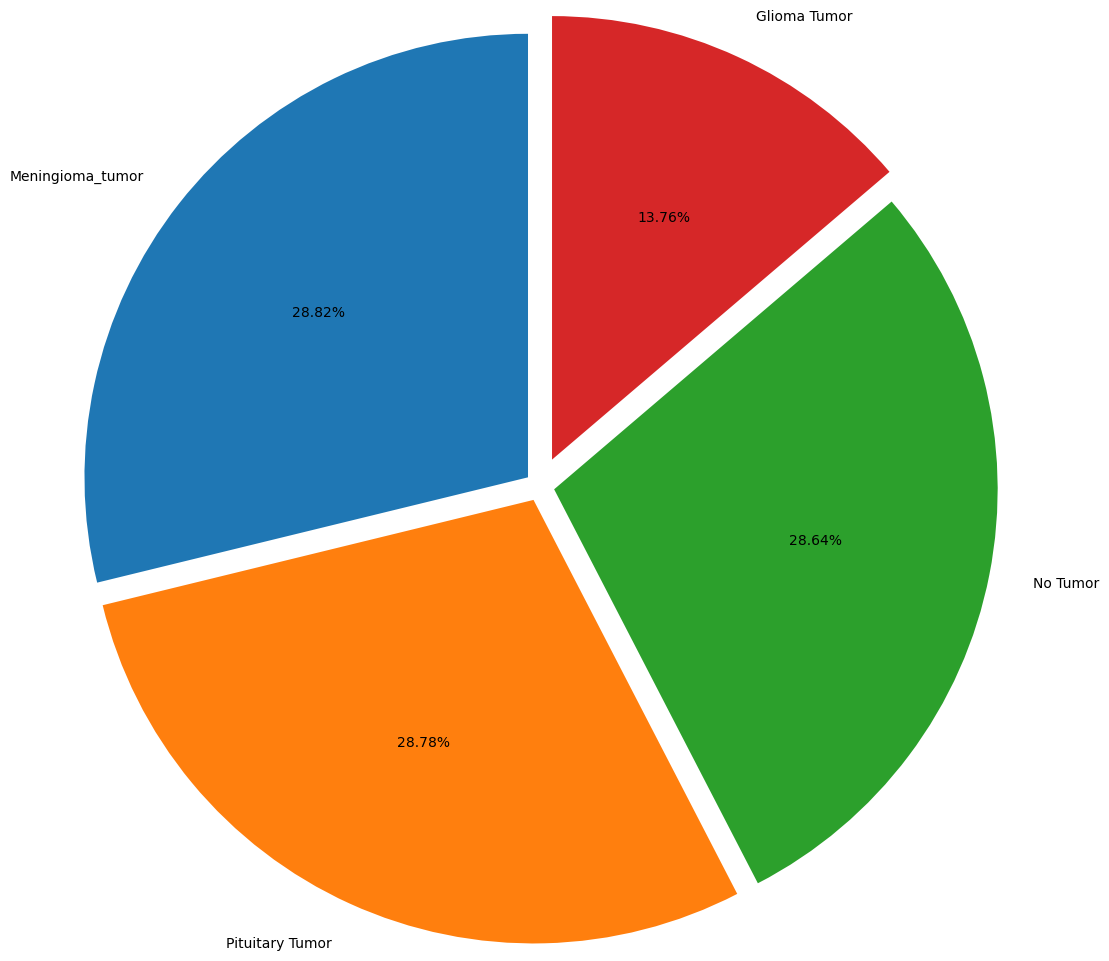

In [7]:
plt.pie(train_data.label.value_counts(),startangle=90,explode=[0.1,0.1,0.1,0.2],autopct='%0.2f%%',
        labels=['Meningioma_tumor', 'Pituitary Tumor', 'No Tumor', 'Glioma Tumor'],radius=3)
plt.show()

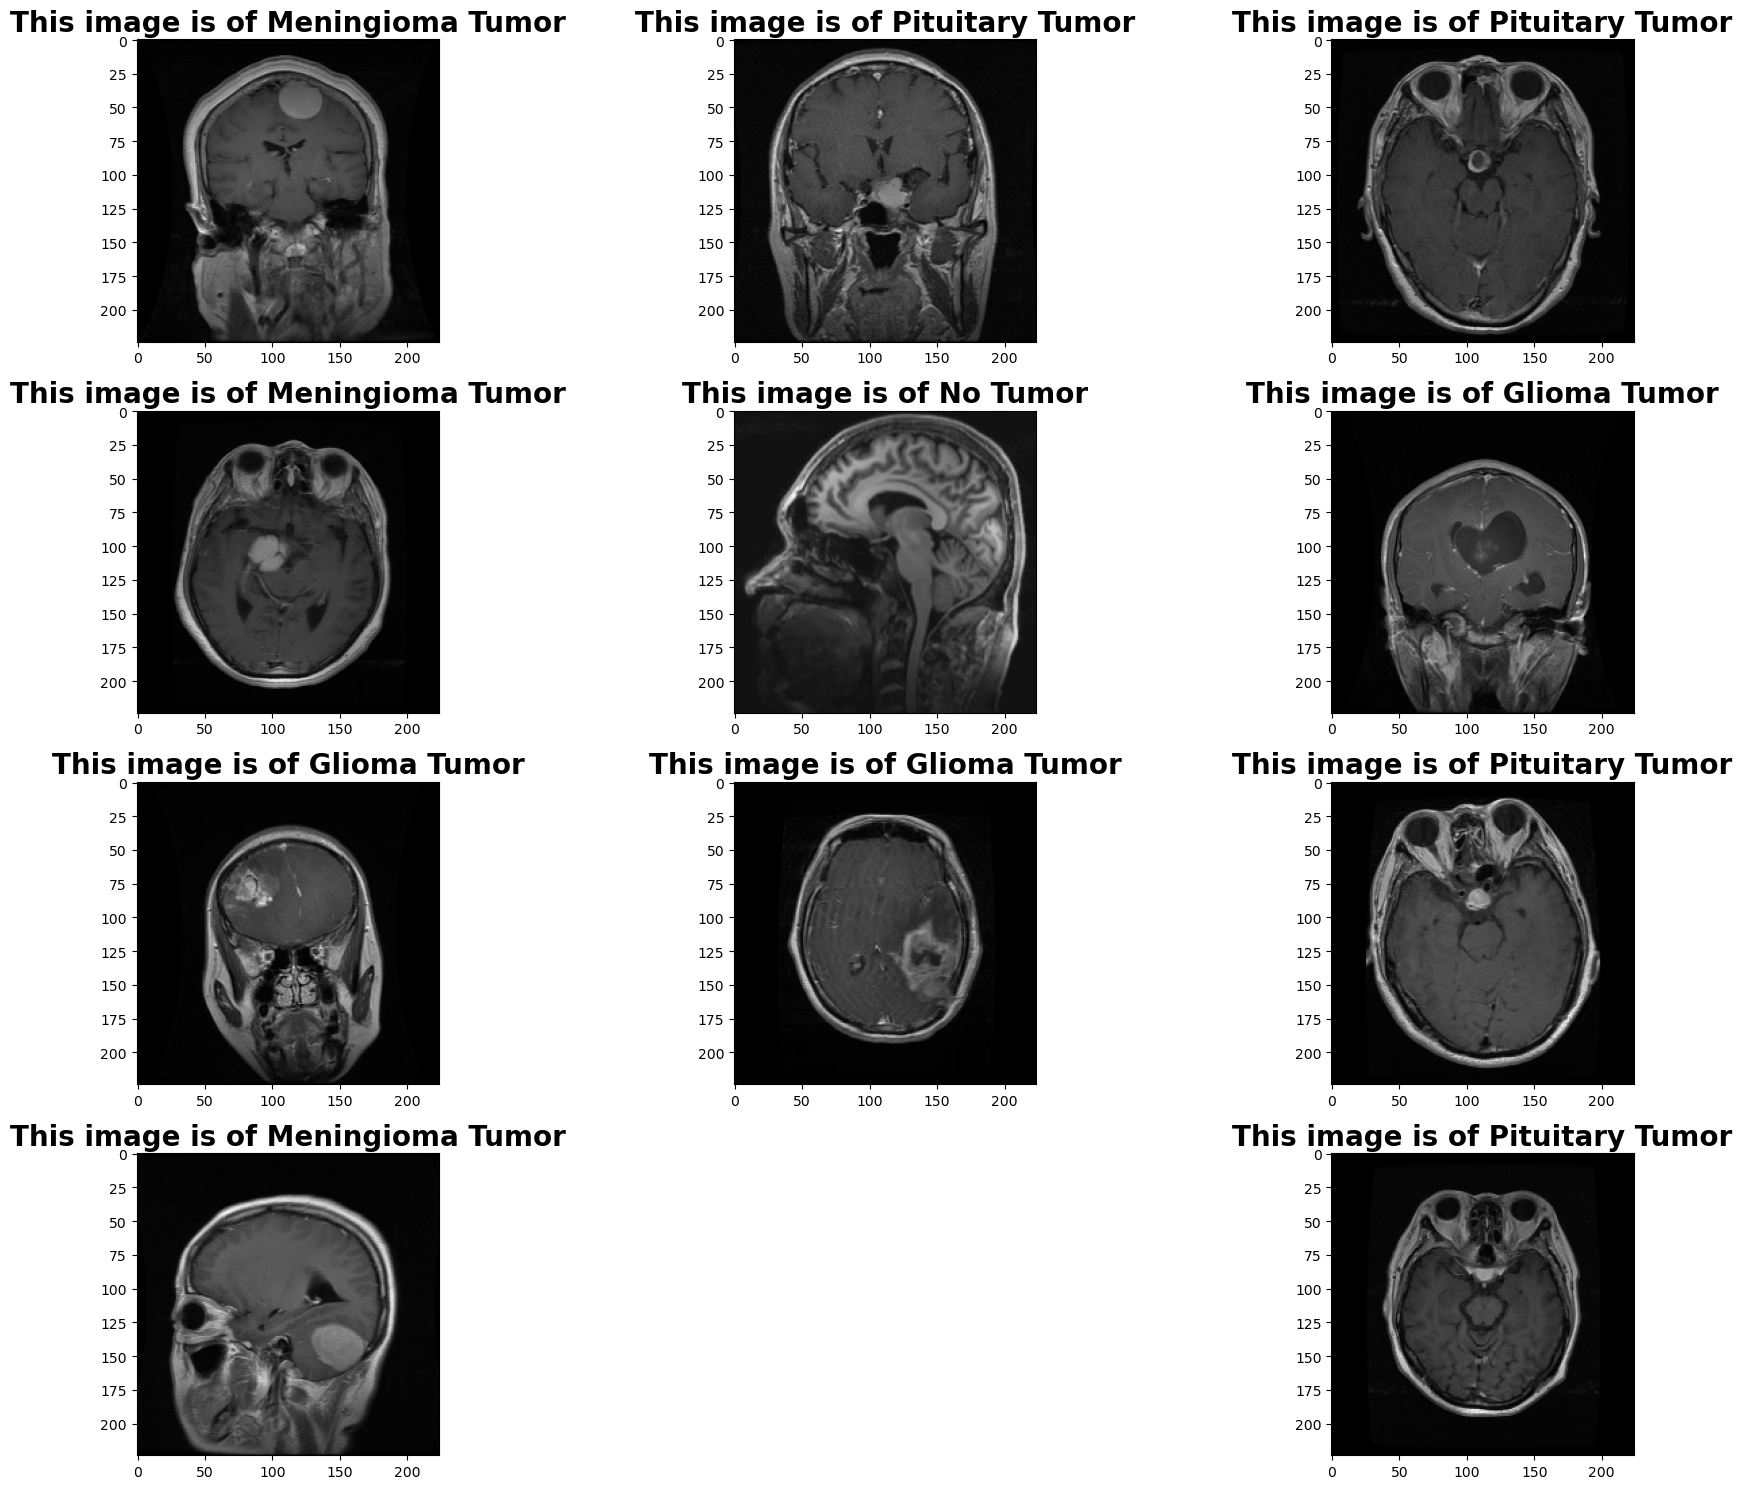

In [8]:
plt.figure(figsize=(20,15))
for i in range(12):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(2000)
    plt.title('This image is of {0}'.format(inverse_classes(train_data.label[index])),fontdict={'size':20,'weight':'bold'})
    plt.imshow(train_data.image[index])
    plt.tight_layout()

In [9]:
#Callbacks functions

In [10]:
early_stop=EarlyStopping(patience=3)
reduceLR=ReduceLROnPlateau(patience=2)

In [11]:
import tensorflow as tf
try:
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  print("All devices: ", tf.config.list_logical_devices('TPU'))
  tpu_strategy = tf.distribute.experimental.TPUStrategy(resolver)
except ValueError:
  tpu_strategy = tf.distribute.get_strategy() 

In [12]:
!pip install graphviz

In [13]:
!pip install pydot

In [14]:
#Traditional CNN approach

In [15]:
# instantiating the model in the strategy scope creates the model on the TPU

with tpu_strategy.scope():
    model_cnn=Sequential()
    model_cnn.add(Input(shape=(224,224,3)))
    model_cnn.add(Conv2D(128,(3,3)))
    model_cnn.add(MaxPooling2D((2,2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(64,(3,3)))
    model_cnn.add(MaxPooling2D((2,2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(32,(3,3)))
    model_cnn.add(MaxPooling2D((2,2)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Flatten())
    model_cnn.add(Dense(128,activation='relu'))
    model_cnn.add(Dropout(0.2))
    model_cnn.add(Dense(64,activation='relu'))
    model_cnn.add(Dense(4,activation='softmax'))
    model_cnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
plot_model(model_cnn)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [17]:
r1=model_cnn.fit(train_x,train_data.label,validation_split=0.1,epochs=70,callbacks=[reduceLR])

Epoch 1/70
81/81 [==============================] - 282s 3s/step - loss: 1.2088 - accuracy: 0.5854 - val_loss: 6.6178 - val_accuracy: 0.1951 - lr: 0.0010
Epoch 2/70
81/81 [==============================] - 269s 3s/step - loss: 0.7386 - accuracy: 0.7278 - val_loss: 0.6619 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 3/70
81/81 [==============================] - 268s 3s/step - loss: 0.5532 - accuracy: 0.7782 - val_loss: 2.8756 - val_accuracy: 0.5645 - lr: 0.0010
Epoch 4/70
81/81 [==============================] - 277s 3s/step - loss: 0.4156 - accuracy: 0.8370 - val_loss: 0.7052 - val_accuracy: 0.7700 - lr: 0.0010
Epoch 5/70
81/81 [==============================] - 266s 3s/step - loss: 0.2748 - accuracy: 0.9001 - val_loss: 0.6827 - val_accuracy: 0.7700 - lr: 1.0000e-04
Epoch 6/70
81/81 [==============================] - 270s 3s/step - loss: 0.2106 - accuracy: 0.9233 - val_loss: 1.1569 - val_accuracy: 0.6794 - lr: 1.0000e-04
Epoch 7/70
81/81 [==============================] - 271s 3s/step - l

Epoch 53/70
81/81 [==============================] - 241s 3s/step - loss: 0.1667 - accuracy: 0.9412 - val_loss: 0.2974 - val_accuracy: 0.8746 - lr: 1.0000e-25
Epoch 54/70
81/81 [==============================] - 241s 3s/step - loss: 0.1664 - accuracy: 0.9373 - val_loss: 0.2972 - val_accuracy: 0.8746 - lr: 1.0000e-25
Epoch 55/70
81/81 [==============================] - 251s 3s/step - loss: 0.1814 - accuracy: 0.9295 - val_loss: 0.2970 - val_accuracy: 0.8711 - lr: 1.0000e-26
Epoch 56/70
81/81 [==============================] - 246s 3s/step - loss: 0.1726 - accuracy: 0.9361 - val_loss: 0.2971 - val_accuracy: 0.8711 - lr: 1.0000e-26
Epoch 57/70
81/81 [==============================] - 241s 3s/step - loss: 0.1620 - accuracy: 0.9350 - val_loss: 0.2971 - val_accuracy: 0.8746 - lr: 1.0000e-27
Epoch 58/70
81/81 [==============================] - 245s 3s/step - loss: 0.1619 - accuracy: 0.9443 - val_loss: 0.2973 - val_accuracy: 0.8746 - lr: 1.0000e-27
Epoch 59/70
81/81 [===========================

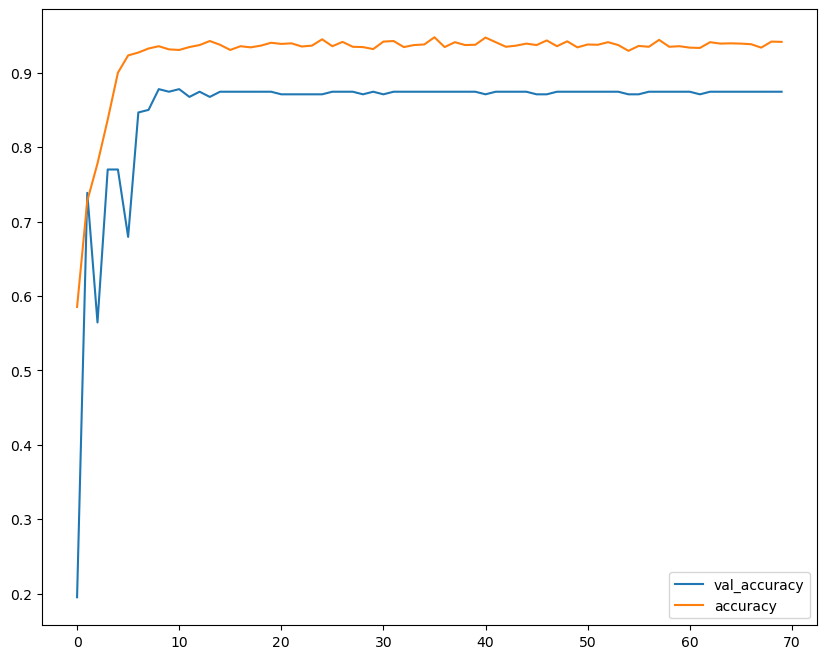

In [18]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_accuracy'])
plt.plot(r1.history['accuracy'])
plt.legend(['val_accuracy','accuracy'])
plt.show()

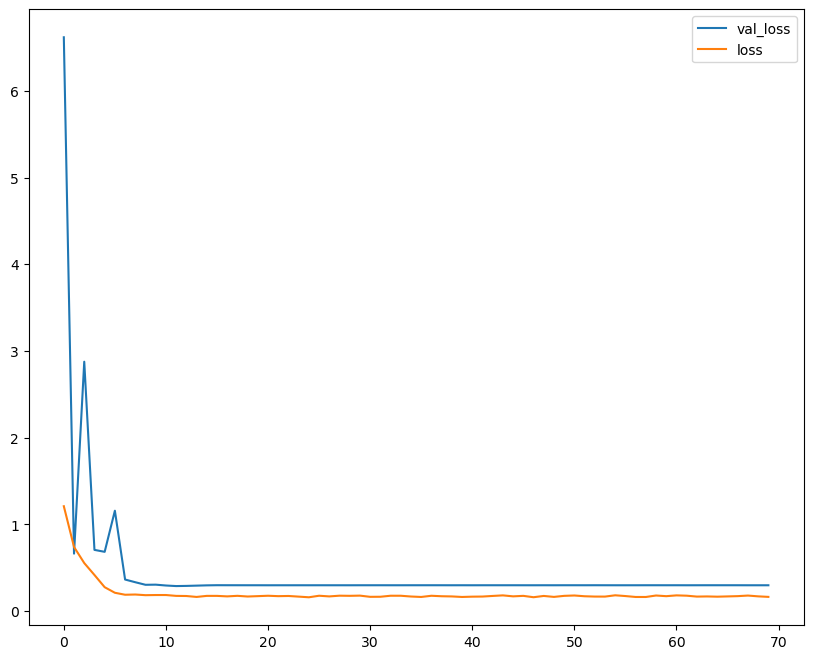

In [19]:
plt.figure(figsize=(10,8))
plt.plot(r1.history['val_loss'])
plt.plot(r1.history['loss'])
plt.legend(['val_loss','loss'])
plt.show()

In [20]:
# Predictions on Test Datasets using VGG16 model

test_pred_transfer=np.argmax(model_cnn.predict(test_x),axis=1)
print(classification_report(test_data.label,test_pred_transfer))

13/13 [==============================] - 10s 687ms/step
              precision    recall  f1-score   support

           0       0.77      0.17      0.28       100
           1       0.71      0.90      0.80       115
           2       0.62      0.95      0.75       105
           3       0.89      0.77      0.83        74

    accuracy                           0.71       394
   macro avg       0.75      0.70      0.66       394
weighted avg       0.74      0.71      0.66       394



In [21]:
#Visualizing Prediction on test dataset

1/1 [==============================] - 0s 42ms/step


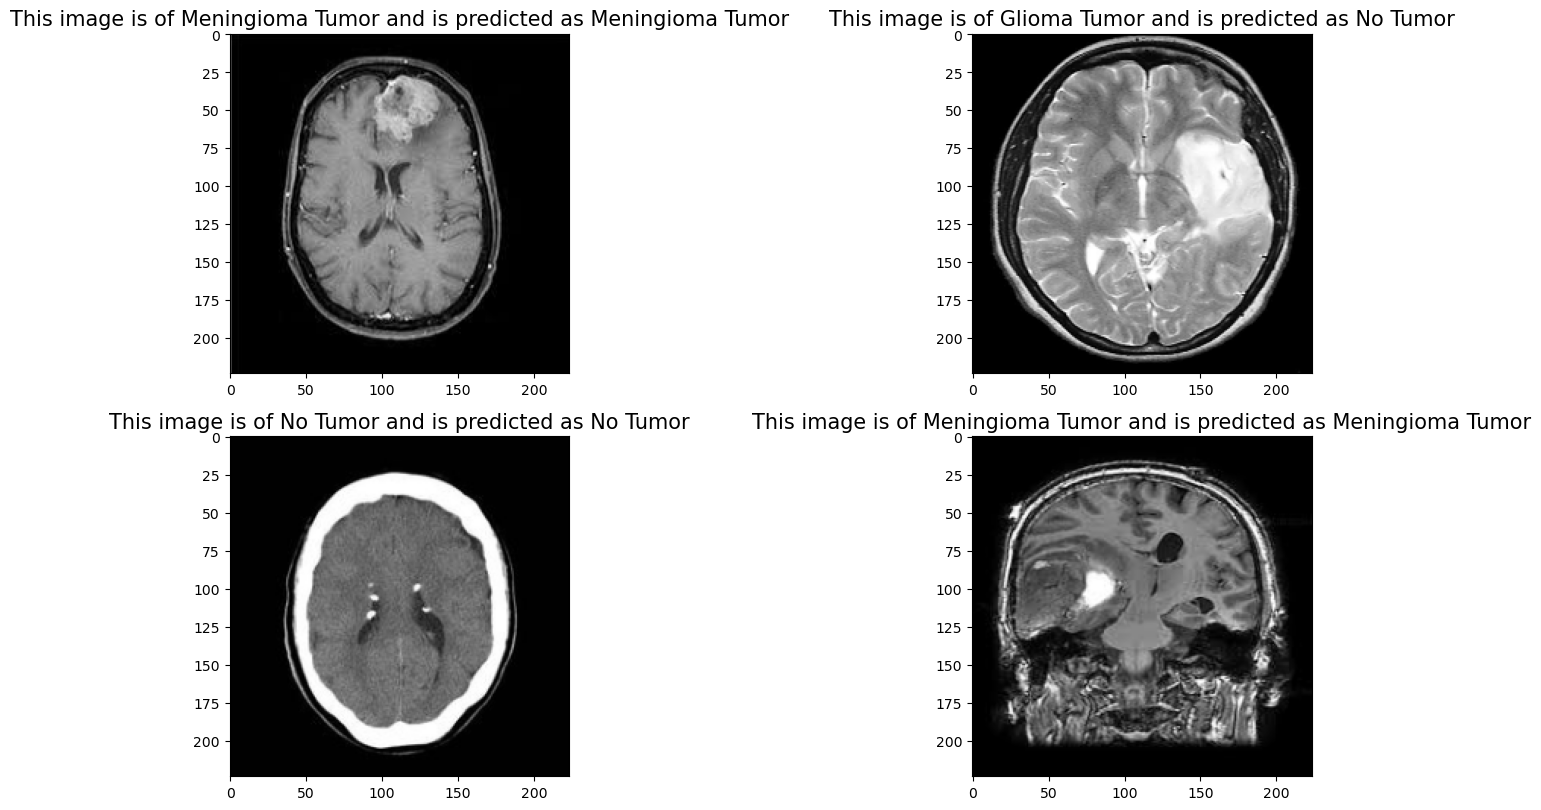

In [22]:
# Prediction using VGG16 model

plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(test_x[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(test_data.label[index]),pred_class),
              fontdict={'size':15})
    plt.imshow(test_x[index])
    plt.tight_layout()
    

1/1 [==============================] - 0s 44ms/step


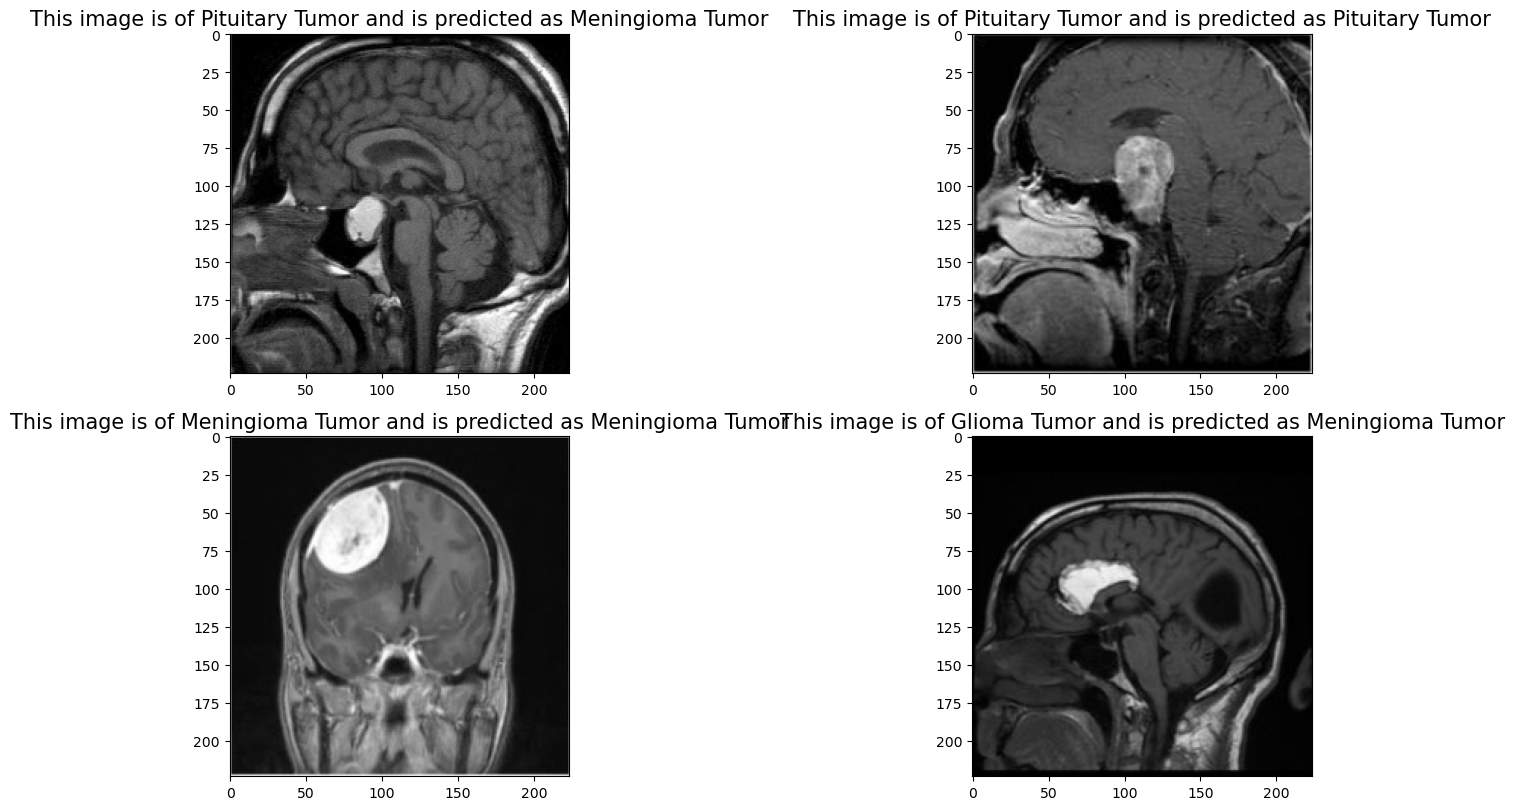

In [23]:
# Prediction using CNN model

plt.figure(figsize=(15,12))
for i in range(4):
    plt.subplot(3,2,(i%12)+1)
    index=np.random.randint(200)
    pred_class=inverse_classes(np.argmax(model_cnn.predict(np.reshape(test_x[index],(-1,224,224,3))),axis=1))
    plt.title('This image is of {0} and is predicted as {1}'.format(inverse_classes(test_data.label[index]),pred_class),
              fontdict={'size':15})
    plt.imshow(test_x[index])
    plt.tight_layout()